# 🔧 Install Required Python Packages

In [48]:
!pip install pandas numpy matplotlib seaborn wordcloud nltk scikit-learn xgboost shap plotly optuna

# 📦 Importing Required Libraries

In [64]:
# ========== System & Utilities ==========
import os
import re
import string
import warnings

# ========== Data Handling ==========
import numpy as np
import pandas as pd
from scipy.stats import uniform, randint

# ========== Natural Language Processing ==========
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download required NLTK data files (run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# ========== Machine Learning ==========
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.model_selection import RandomizedSearchCV


# ========== Hyperparameter Tuning ==========
import optuna

# ========== Model Interpretability ==========
import shap

# ========== Visualization ==========
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS

# ========== Warnings Configuration ==========
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ganeshmanepalli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ganeshmanepalli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ganeshmanepalli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 📁 Load and Label the Dataset

In [3]:
def load_and_label_news(fake_path="Fake.csv", real_path="True.csv", random_seed=42):
    """
    Load fake and real news datasets, assign binary labels, combine and shuffle.

    Parameters:
    - fake_path (str): File path to the fake news CSV.
    - real_path (str): File path to the real news CSV.
    - random_seed (int): Seed for reproducible shuffling (default=42).

    Returns:
    - pd.DataFrame: Combined and shuffled dataset with labels.
    """
    # Load datasets
    fake_df = pd.read_csv(fake_path)
    real_df = pd.read_csv(real_path)

    # Assign labels
    fake_df["label"] = 0
    real_df["label"] = 1

    # Combine and shuffle
    df = pd.concat([fake_df, real_df], axis=0).reset_index(drop=True)
    df = df.sample(frac=1, random_state=random_seed).reset_index(drop=True)

    return df

In [4]:
df = load_and_label_news("Fake.csv", "True.csv")
df.head()

title  \
0  Ben Stein Calls Out 9th Circuit Court: Committ...   
1  Trump drops Steve Bannon from National Securit...   
2  Puerto Rico expects U.S. to lift Jones Act shi...   
3   OOPS: Trump Just Accidentally Confirmed He Le...   
4  Donald Trump heads for Scotland to reopen a go...   

                                                text       subject  \
0  21st Century Wire says Ben Stein, reputable pr...       US_News   
1  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...  politicsNews   
3  On Monday, Donald Trump once again embarrassed...          News   
4  GLASGOW, Scotland (Reuters) - Most U.S. presid...  politicsNews   

                  date  label  
0    February 13, 2017      0  
1       April 5, 2017       1  
2  September 27, 2017       1  
3         May 22, 2017      0  
4       June 24, 2016       1

## ✅ Function to Map Subjects into High-Level Domains

In [5]:
def assign_domain(df, subject_col='subject'):
    """
    Map fine-grained subject labels to broader domain categories:
    Politics, News, and Other.

    Parameters:
    df (pd.DataFrame): The input dataframe containing a subject column.
    subject_col (str): The column name for subject labels.

    Returns:
    pd.DataFrame: Updated dataframe with a new 'domain' column.
    """
    domain_map = {
        'politicsNews': 'Politics',
        'politics': 'Politics',
        'left-news': 'Politics',
        'Government News': 'Politics',
        'worldnews': 'News',
        'News': 'News',
        'US_News': 'News',
        'Middle-east': 'Other'
    }
    df['domain'] = df[subject_col].map(domain_map)
    return df

df = assign_domain(df)

# 📊 Exploratory Data Analysis (EDA)

## 📌 Basic Structure and Class Distribution

In [6]:
# Dataset shape: rows and columns
print(f"Dataset shape: {df.shape[0]} rows, {df.shape[1]} columns\n")

Dataset shape: 44898 rows, 6 columns



In [7]:
# Dataset information: column names, types, non-null counts
print("Dataset info:\n")
df.info()

Dataset info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
 5   domain   44898 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.1+ MB


In [8]:
# Display first 5 rows
print("\nFirst 5 rows:")
display(df.head())


First 5 rows:


title  \
0  Ben Stein Calls Out 9th Circuit Court: Committ...   
1  Trump drops Steve Bannon from National Securit...   
2  Puerto Rico expects U.S. to lift Jones Act shi...   
3   OOPS: Trump Just Accidentally Confirmed He Le...   
4  Donald Trump heads for Scotland to reopen a go...   

                                                text       subject  \
0  21st Century Wire says Ben Stein, reputable pr...       US_News   
1  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...  politicsNews   
3  On Monday, Donald Trump once again embarrassed...          News   
4  GLASGOW, Scotland (Reuters) - Most U.S. presid...  politicsNews   

                  date  label    domain  
0    February 13, 2017      0      News  
1       April 5, 2017       1  Politics  
2  September 27, 2017       1  Politics  
3         May 22, 2017      0      News  
4       June 24, 2016       1  Politics

In [9]:
# Display last 5 rows
print("\nLast 5 rows:")
display(df.tail())


Last 5 rows:


title  \
44893  UNREAL! CBS’S TED KOPPEL Tells Sean Hannity He...   
44894  PM May seeks to ease Japan's Brexit fears duri...   
44895  Merkel: Difficult German coalition talks can r...   
44896   Trump Stole An Idea From North Korean Propaga...   
44897  BREAKING: HILLARY CLINTON’S STATE DEPARTMENT G...   

                                                    text    subject  \
44893                                                      politics   
44894  LONDON/TOKYO (Reuters) - British Prime Ministe...  worldnews   
44895  BERLIN (Reuters) - Chancellor Angela Merkel sa...  worldnews   
44896  Jesus f*cking Christ our President* is a moron...       News   
44897  IF SHE S NOT TOAST NOW THEN WE RE IN BIGGER TR...   politics   

                     date  label    domain  
44893        Mar 27, 2017      0  Politics  
44894    August 29, 2017       1      News  
44895  November 16, 2017       1      News  
44896       July 14, 2017      0      News  
44897        Apr 23, 2015      0  Politics

In [10]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
title      0
text       0
subject    0
date       0
label      0
domain     0
dtype: int64


In [11]:
# Check for duplicate rows
num_duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {num_duplicates}")


Number of duplicate rows: 209


### 🧹 Data Cleaning

In [12]:
# Drop duplicate rows
df = df.drop_duplicates()
print(f"✅ Duplicates removed. Dataset now has {df.shape[0]} rows.")

✅ Duplicates removed. Dataset now has 44689 rows.


In [13]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Check for rows with invalid or missing dates
missing_dates = df['date'].isnull().sum()
print(f"🕒 Rows with invalid dates: {missing_dates}")

🕒 Rows with invalid dates: 10


In [14]:
# Identify and display rows where 'date' could not be parsed
invalid_date_rows = df[df['date'].isnull()]
print(f"🕵️‍♂️ Showing {len(invalid_date_rows)} rows with invalid 'date' values:")
display(invalid_date_rows)

🕵️‍♂️ Showing 10 rows with invalid 'date' values:


title  \
6408   https://100percentfedup.com/video-hillary-aske...   
7367   https://fedup.wpengine.com/wp-content/uploads/...   
9276   https://fedup.wpengine.com/wp-content/uploads/...   
10886  https://100percentfedup.com/served-roy-moore-v...   
15485  https://fedup.wpengine.com/wp-content/uploads/...   
19300                                           Homepage   
25820  https://100percentfedup.com/12-yr-old-black-co...   
26402  https://fedup.wpengine.com/wp-content/uploads/...   
27725  https://fedup.wpengine.com/wp-content/uploads/...   
40812  https://fedup.wpengine.com/wp-content/uploads/...   

                                                    text          subject  \
6408   https://100percentfedup.com/video-hillary-aske...         politics   
7367   https://fedup.wpengine.com/wp-content/uploads/...        left-news   
9276   https://fedup.wpengine.com/wp-content/uploads/...  Government News   
10886  https://100percentfedup.com/served-roy-moore-v...         politics   
15485  https://fedup.wpengine.com/wp-content/uploads/...  Government News   
19300  [vc_row][vc_column width= 1/1 ][td_block_trend...        left-news   
25820  https://100percentfedup.com/12-yr-old-black-co...         politics   
26402  https://fedup.wpengine.com/wp-content/uploads/...         politics   
27725  https://fedup.wpengine.com/wp-content/uploads/...         politics   
40812  https://fedup.wpengine.com/wp-content/uploads/...        left-news   

      date  label    domain  
6408   NaT      0  Politics  
7367   NaT      0  Politics  
9276   NaT      0  Politics  
10886  NaT      0  Politics  
15485  NaT      0  Politics  
19300  NaT      0  Politics  
25820  NaT      0  Politics  
26402  NaT      0  Politics  
27725  NaT      0  Politics  
40812  NaT      0  Politics

In [15]:
# Drop rows where 'date' could not be parsed
df = df.dropna(subset=['date'])
df.reset_index(drop= True, inplace = True)
print(f"✅ Final dataset after cleaning has {df.shape[0]} rows.")

✅ Final dataset after cleaning has 44679 rows.


## 🔎 Univariate Analysis

### 📊 Distribution of Real vs Fake News 

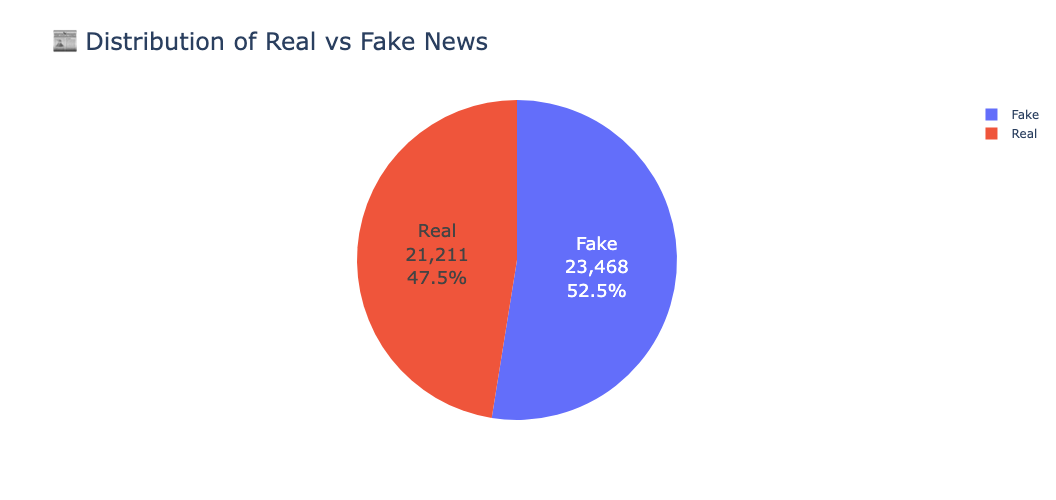

In [16]:
def plot_real_vs_fake_pie(dataframe, label_col='label'):
    label_counts = dataframe[label_col].value_counts().rename({0: "Fake", 1: "Real"})
    colors = ['#636EFA', '#EF553B']  

    fig = go.Figure(
        data=[go.Pie(
            labels=label_counts.index,
            values=label_counts.values,
            marker=dict(colors=colors),
            textinfo='percent+label+value',
            textfont=dict(size=18)
        )]
    )

    fig.update_layout(
        title_text='📰 Distribution of Real vs Fake News',
        title_font=dict(size=24),
        height=500,
        width=600
    )

    fig.show()

plot_real_vs_fake_pie(df)

### 📊 Distribution of News Domain

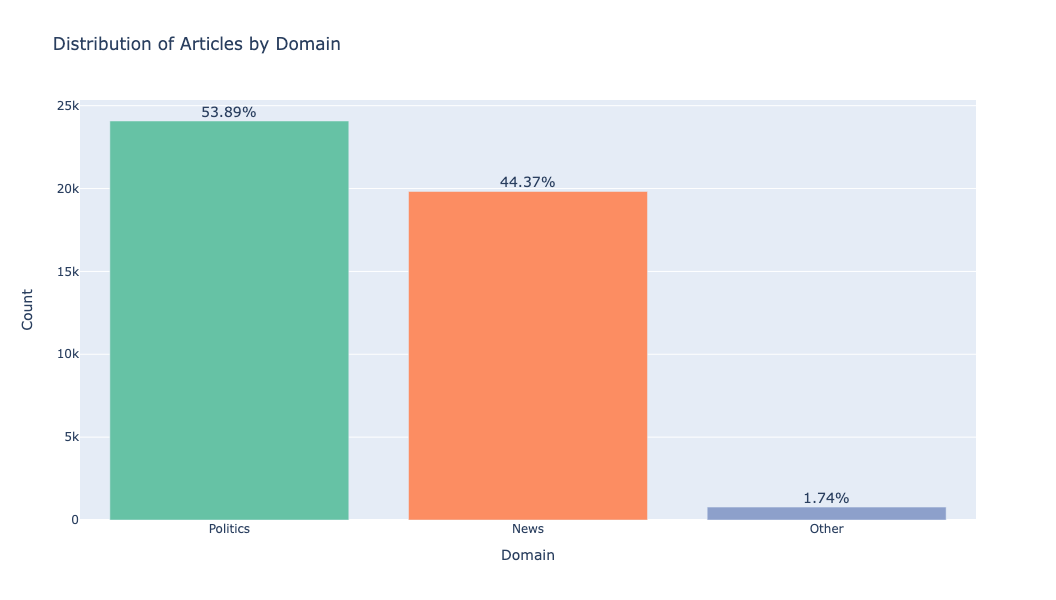

In [17]:
def plot_domain_distribution(dataframe, domain_col='domain'):
    domain_counts = dataframe[domain_col].value_counts()
    total = domain_counts.sum()
    percentages = (domain_counts / total * 100).round(2)

    fig = px.bar(
        x=domain_counts.index,
        y=domain_counts.values,
        title="Distribution of Articles by Domain",
        labels={'x': 'Domain', 'y': 'Count'},
        color=domain_counts.index,
        color_discrete_sequence=px.colors.qualitative.Set2
    )

    annotations = []
    for i, (count, pct) in enumerate(zip(domain_counts.values, percentages)):
        annotations.append(dict(
            x=domain_counts.index[i],
            y=count,
            text=f"{pct}%",
            showarrow=False,
            yshift=10,
            font=dict(size=14)
        ))

    fig.update_traces(
        hovertemplate='<b>%{x}</b><br>Count: %{y}<extra></extra>'
    )

    fig.update_layout(
        xaxis_tickangle=0,
        height=600,
        showlegend=False,
        annotations=annotations
    )

    fig.show()

plot_domain_distribution(df)

### 📊 Distribution of News Topics

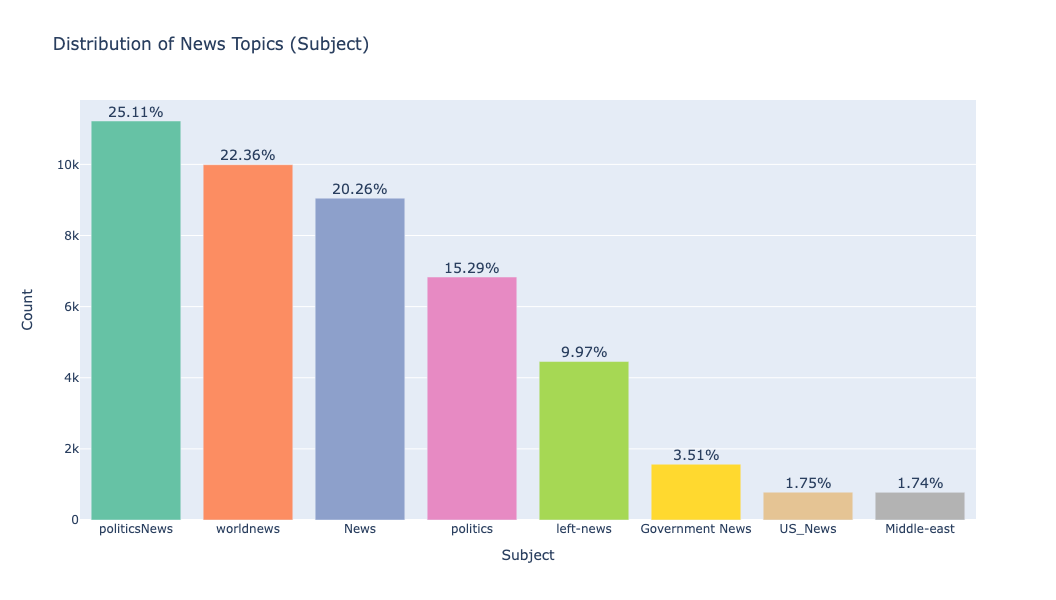

In [18]:
def plot_subject_distribution(dataframe, subject_col='subject'):
    subject_counts = dataframe[subject_col].value_counts()
    total = subject_counts.sum()
    percentages = (subject_counts / total * 100).round(2)

    fig = px.bar(
        x=subject_counts.index,
        y=subject_counts.values,
        title="Distribution of News Topics (Subject)",
        labels={'x': 'Subject', 'y': 'Count'},
        color=subject_counts.index,
        color_discrete_sequence=px.colors.qualitative.Set2
    )

    annotations = []
    for i, (count, pct) in enumerate(zip(subject_counts.values, percentages)):
        annotations.append(dict(
            x=subject_counts.index[i],
            y=count,
            text=f"{pct}%",
            showarrow=False,
            yshift=10,
            font=dict(size=14)
        ))
        
    fig.update_traces(
        hovertemplate='<b>%{x}</b><br>Count: %{y}<extra></extra>'
    )

    fig.update_layout(
        xaxis_tickangle=0,
        height=600,
        showlegend=False,
        annotations=annotations
    )

    fig.show()

plot_subject_distribution(df)

### 📊 Distribution of Text Length and WordCloud

In [26]:
def plot_text_length_distribution(dataframe, text_col='text', nbins=50):
    dataframe['text_length'] = dataframe[text_col].apply(lambda x: len(str(x).split()))
    
    fig = px.histogram(
        dataframe,
        x='text_length',
        nbins=nbins,
        title='Distribution of Text Length (Number of Words)',
        labels={'text_length': 'Text Length (words)'},
        color_discrete_sequence=['#636EFA'] 
    )
    fig.update_layout(showlegend=False)
    fig.show()

def generate_wordcloud(dataframe, title):
    text = " ".join(dataframe['text'].astype(str))
    wc = WordCloud(stopwords=STOPWORDS, background_color='white', width=800, height=400).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

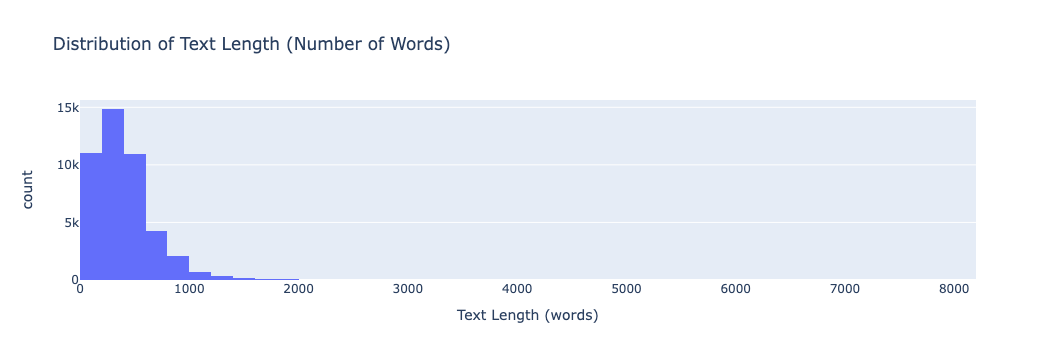

In [27]:
plot_text_length_distribution(df)

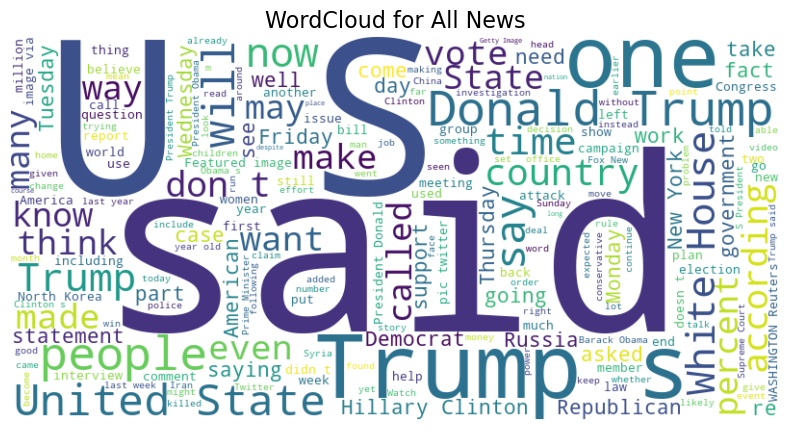

In [28]:
generate_wordcloud(df, "WordCloud for All News")

### 📅 4. Minimum and Maximum Dates

In [29]:
min_date = df['date'].min()
max_date = df['date'].max()
print(f"🗓️ News articles range from {min_date.date()} to {max_date.date()}")

🗓️ News articles range from 2015-03-31 to 2018-02-19


## 📈 Bi-variate Analysis

### 🏷️ Distribution of News Domains by Label (Fake vs Real)

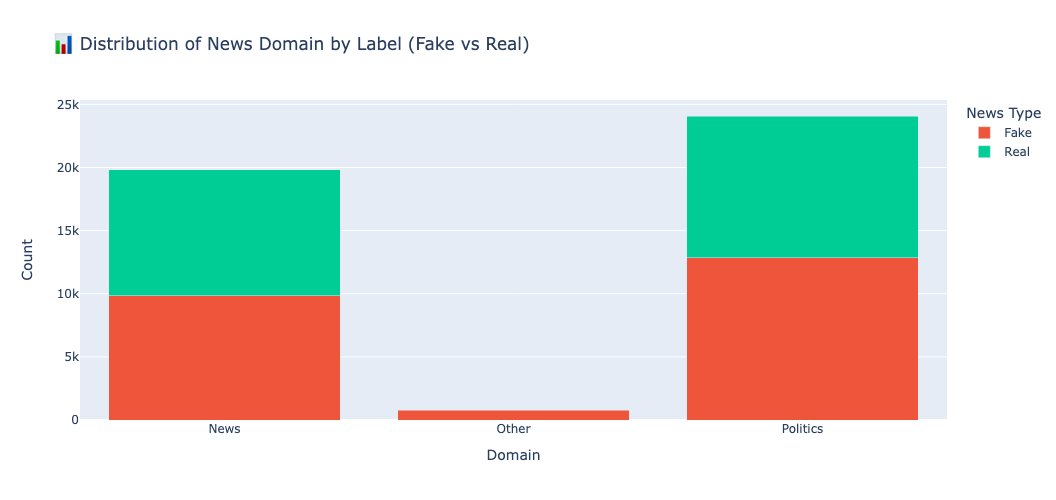

In [30]:
def plot_domain_label_distribution(df, domain_col='domain', label_col='label'):
    label_map = {0: 'Fake', 1: 'Real'}
    df['label_name'] = df[label_col].map(label_map)

    count_data = df.groupby([domain_col, 'label_name']).size().reset_index(name='count')

    total_counts = count_data.groupby(domain_col)['count'].sum().reset_index()
    total_counts = total_counts.sort_values(by='count', ascending=False)

    sorted_domains = total_counts[domain_col].tolist()

    count_data[domain_col] = pd.Categorical(count_data[domain_col], categories=sorted_domains, ordered=True)

    fig = px.bar(
        count_data,
        x=domain_col,
        y='count',
        color='label_name',
        title="📊 Distribution of News Domain by Label (Fake vs Real)",
        labels={domain_col: 'Domain', 'count': 'Count', 'label_name': 'News Type'},
        color_discrete_map={'Fake': '#EF553B', 'Real': '#00CC96'}
    )
    fig.update_layout(barmode='stack', height=500, width=1000)
    fig.show()

plot_domain_label_distribution(df)

# Text Preprocessing

In [31]:
def preprocess_text(text):
    """
    Preprocesses input text by performing the following steps:
    
    1. Convert text to lowercase to ensure uniformity.
    2. Remove content inside square brackets (e.g., citations or notes).
    3. Remove URLs (http, https, www) to avoid irrelevant links.
    4. Remove HTML tags if present.
    5. Remove all punctuation to focus on words only.
    6. Replace newline characters with spaces to maintain sentence flow.
    7. Remove words containing digits (e.g., dates, numbers within words).
    8. Remove extra whitespace and strip leading/trailing spaces.
    9. Tokenize text into individual words for further processing.
    10. Lemmatize tokens to reduce words to their base or dictionary form.
    11. Remove common English stopwords that add little semantic value.
    12. Join the cleaned tokens back into a single string.

    Args:
        text (str): The raw input text to preprocess.

    Returns:
        str: The cleaned and preprocessed text.
    """
    
    # Convert text to lowercase for case-insensitive processing
    text = text.lower()
    
    # Remove text inside square brackets (e.g., citations like [1], [note])
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove URLs starting with http, https, or www to exclude links
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove HTML tags if any, e.g., <div>, <a>, etc.
    text = re.sub(r'<.*?>', '', text)
    
    # Remove punctuation characters to clean the text
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    
    # Replace newline characters with space to maintain word separation
    text = re.sub(r'\n', ' ', text)
    
    # Remove words containing numbers (e.g., '2023data' or 'abc123')
    text = re.sub(r'\w*\d\w*', '', text)
    
    # Remove extra spaces and trim leading/trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize text into words for lemmatization and stopword removal
    words = word_tokenize(text)
    
    # Initialize lemmatizer to convert words to their base form
    lemmatizer = WordNetLemmatizer()
    
    # Lemmatize each token to reduce inflectional forms (e.g., 'running' -> 'run')
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Define English stopwords to remove common non-informative words
    stop_words = set(stopwords.words('english'))
    
    # Remove stopwords from the token list
    words = [word for word in words if word not in stop_words]
    
    # Join cleaned tokens back into a single string separated by spaces
    cleaned_text = ' '.join(words)
    
    return cleaned_text

In [32]:
# Apply the preprocessing function to the 'text' column and create a new column 'cleaned_text'
df['cleaned_text'] = df['text'].apply(preprocess_text)

# 🧠 Feature Extraction and Data Splitting

In [33]:
X = df['cleaned_text']
y = df['label']

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=45, stratify=y
)

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_vec = vectorizer.fit_transform(X_train)

# Transform the test data using the trained vectorizer
X_test_vec = vectorizer.transform(X_test)

# ⚙️ Model Training

In [56]:
xgb_model = XGBClassifier(
    objective='binary:logistic',  # Binary classification
    eval_metric='logloss',        # Logarithmic loss for evaluation
    max_depth=6,                  # Control model complexity
    learning_rate=0.1,            # Step size shrinkage (eta)
    n_estimators=100,             # Number of boosting rounds
    use_label_encoder=False,      # Avoid deprecation warning
    early_stopping_rounds=10,     # Stop early if no improvement
    random_state=45               # Reproducibility
)

# Train with validation for early stopping
xgb_model.fit(
    X_train_vec, y_train,
    eval_set=[(X_test_vec, y_test)], 
    verbose=True  # Print progress
)

[0]	validation_0-logloss:0.59969
[1]	validation_0-logloss:0.52314
[2]	validation_0-logloss:0.45932
[3]	validation_0-logloss:0.40545
[4]	validation_0-logloss:0.35936
[5]	validation_0-logloss:0.31983
[6]	validation_0-logloss:0.28548
[7]	validation_0-logloss:0.25548
[8]	validation_0-logloss:0.22927
[9]	validation_0-logloss:0.20619
[10]	validation_0-logloss:0.18587
[11]	validation_0-logloss:0.16792
[12]	validation_0-logloss:0.15197
[13]	validation_0-logloss:0.13775
[14]	validation_0-logloss:0.12512
[15]	validation_0-logloss:0.11388
[16]	validation_0-logloss:0.10392
[17]	validation_0-logloss:0.09497
[18]	validation_0-logloss:0.08682
[19]	validation_0-logloss:0.07941
[20]	validation_0-logloss:0.07308
[21]	validation_0-logloss:0.06706
[22]	validation_0-logloss:0.06182
[23]	validation_0-logloss:0.05702
[24]	validation_0-logloss:0.05274
[25]	validation_0-logloss:0.04896
[26]	validation_0-logloss:0.04550
[27]	validation_0-logloss:0.04229
[28]	validation_0-logloss:0.03931
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=45, ...)

# 📈 Model Evaluation

Confusion Matrix:
[[4680   14]
 [   7 4235]]

Accuracy: 0.9976
Precision: 0.9967
Recall: 0.9983
F1 Score: 0.9975
ROC AUC Score: 0.9999


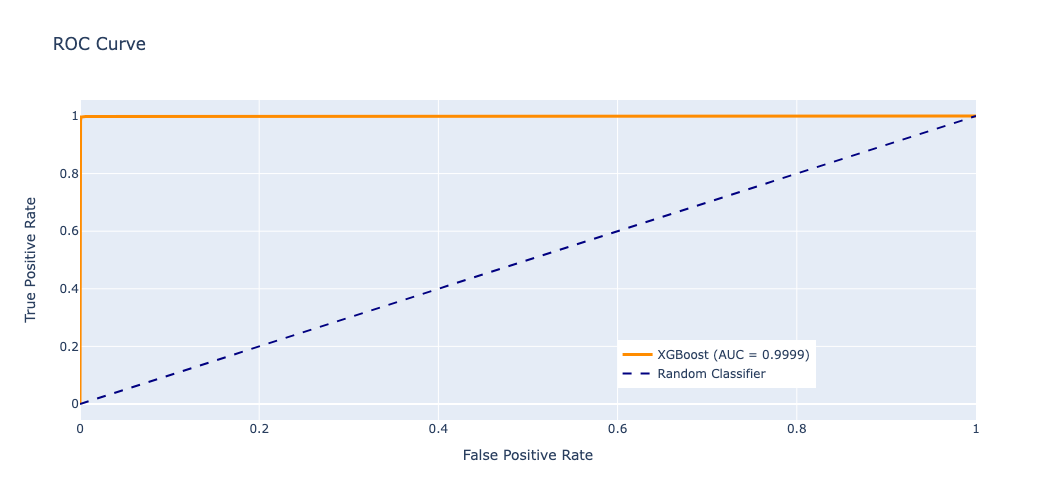

In [57]:
y_pred_proba = xgb_model.predict_proba(X_test_vec)[:, 1]  
y_pred = xgb_model.predict(X_test_vec)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print metrics with explanation for accuracy
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot ROC Curve using Plotly
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'XGBoost (AUC = {roc_auc:.4f})',
                         line=dict(color='darkorange', width=3)))
fig.add_trace(go.Scatter(x=[0,1], y=[0,1], mode='lines', name='Random Classifier',
                         line=dict(color='navy', width=2, dash='dash')))

fig.update_layout(
    title='ROC Curve',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    width=700,
    height=500,
    legend=dict(x=0.6, y=0.1)
)

fig.show()

## 📊 Domain Specific Accuracy 

          Accuracy
Domain            
Politics  0.996260
News      0.999243
Other     1.000000


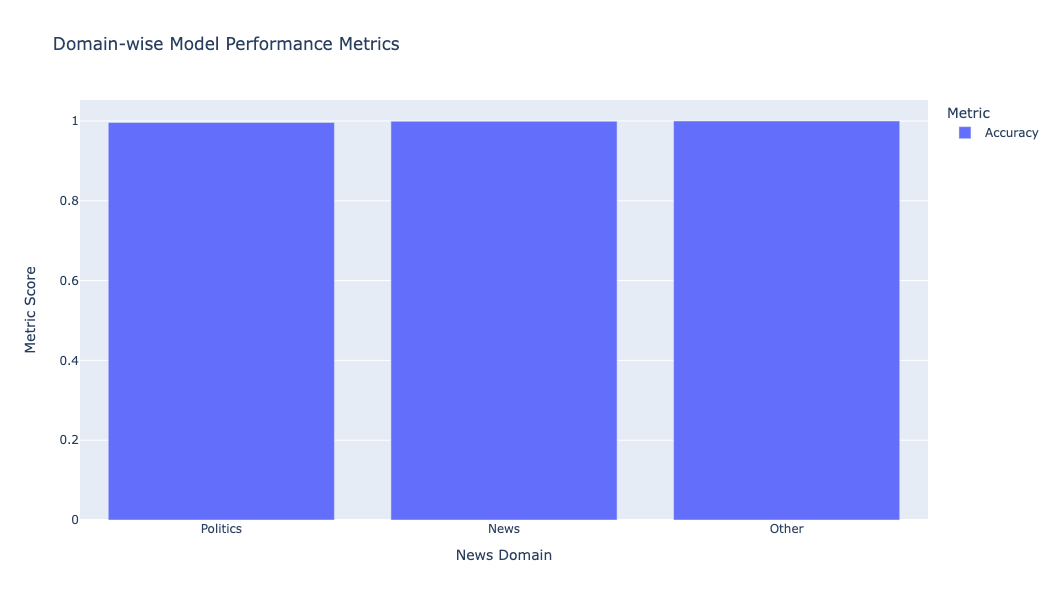

In [58]:
test_data = pd.DataFrame({
    'cleaned_text': X_test,
    'label': y_test,
    'domain': df.loc[y_test.index, 'domain']  
})

y_pred_proba = xgb_model.predict_proba(X_test_vec)[:, 1]
y_pred = xgb_model.predict(X_test_vec)

test_data['y_pred'] = y_pred
test_data['y_pred_proba'] = y_pred_proba

def domain_metrics(subset):
    y_true = subset['label']
    y_pred = subset['y_pred']
    y_proba = subset['y_pred_proba']
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
    }

metrics_list = []
for domain in test_data['domain'].unique():
    domain_subset = test_data[test_data['domain'] == domain]
    metrics = domain_metrics(domain_subset)
    metrics['Domain'] = domain
    metrics_list.append(metrics)

metrics_df = pd.DataFrame(metrics_list).set_index('Domain')

print(metrics_df)

metrics_long = metrics_df.reset_index().melt(id_vars='Domain', var_name='Metric', value_name='Score')

fig = px.bar(
    metrics_long,
    x='Domain',
    y='Score',
    color='Metric',
    barmode='group',
    title="Domain-wise Model Performance Metrics",
    height=600,
    labels={'Score': 'Metric Score', 'Domain': 'News Domain'}
)
fig.show()

# 🧠 Interpretability

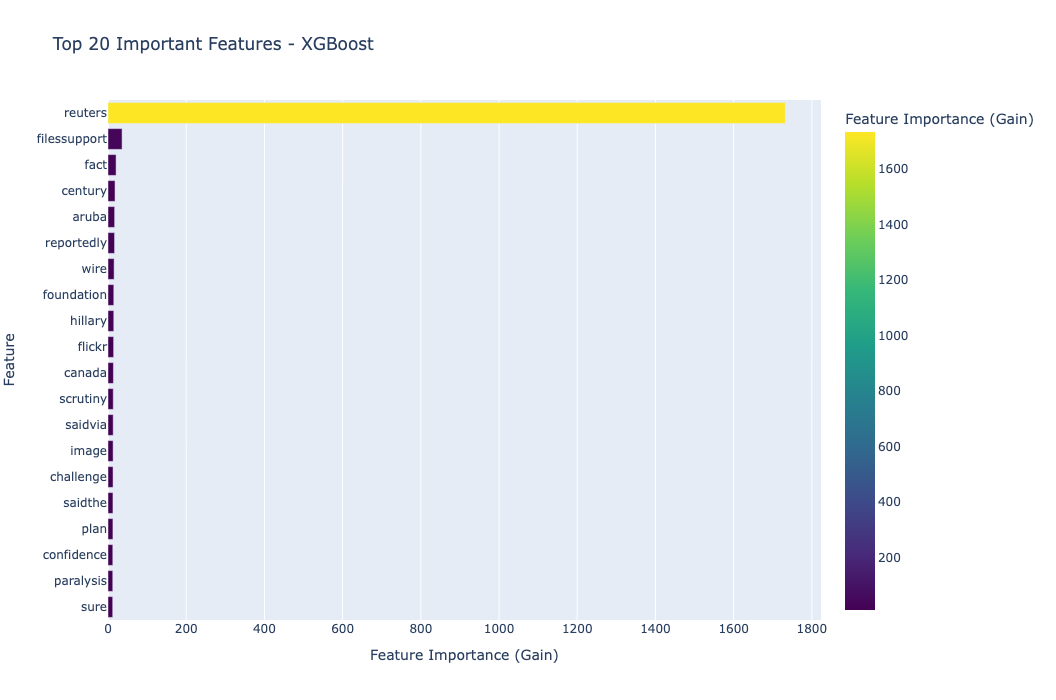

In [59]:
feature_names = vectorizer.get_feature_names_out()
importance = xgb_model.get_booster().get_score(importance_type='gain')
importance_named = {feature_names[int(k[1:])]: v for k, v in importance.items()}
sorted_importance = sorted(importance_named.items(), key=lambda x: x[1], reverse=True)

df_importance = pd.DataFrame(sorted_importance[:20], columns=['Feature', 'Importance'])
fig = px.bar(
    df_importance,
    x='Importance',
    y='Feature',
    orientation='h',
    title='Top 20 Important Features - XGBoost',
    labels={'Importance': 'Feature Importance (Gain)', 'Feature': 'Feature'},
    color='Importance',
    color_continuous_scale='Viridis'
)

fig.update_layout(yaxis={'categoryorder': 'total ascending'}, height=700, width=900)
fig.show()

## 📊 Domain Specific Interpretability

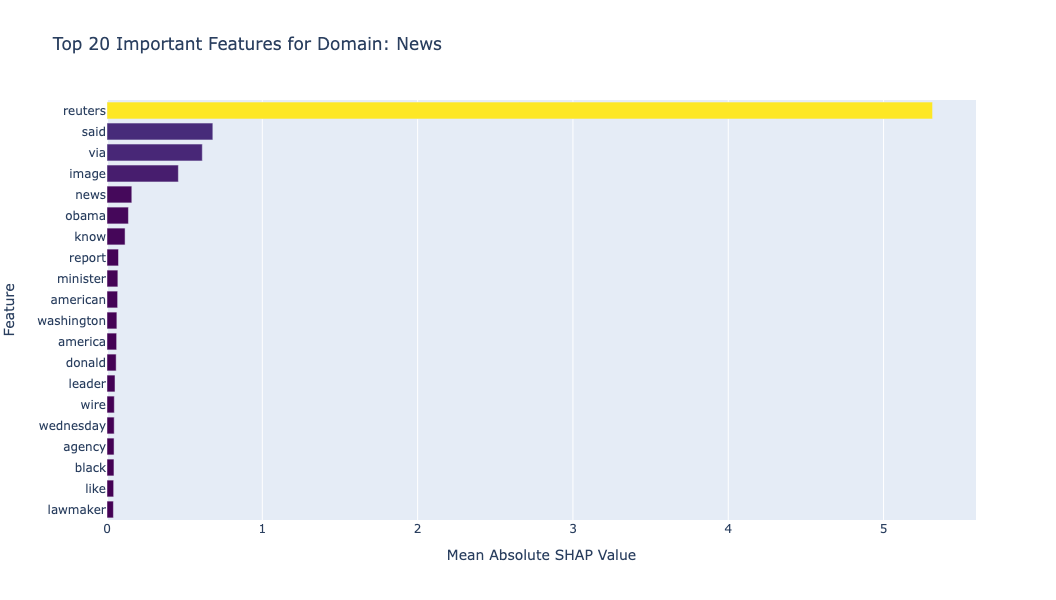

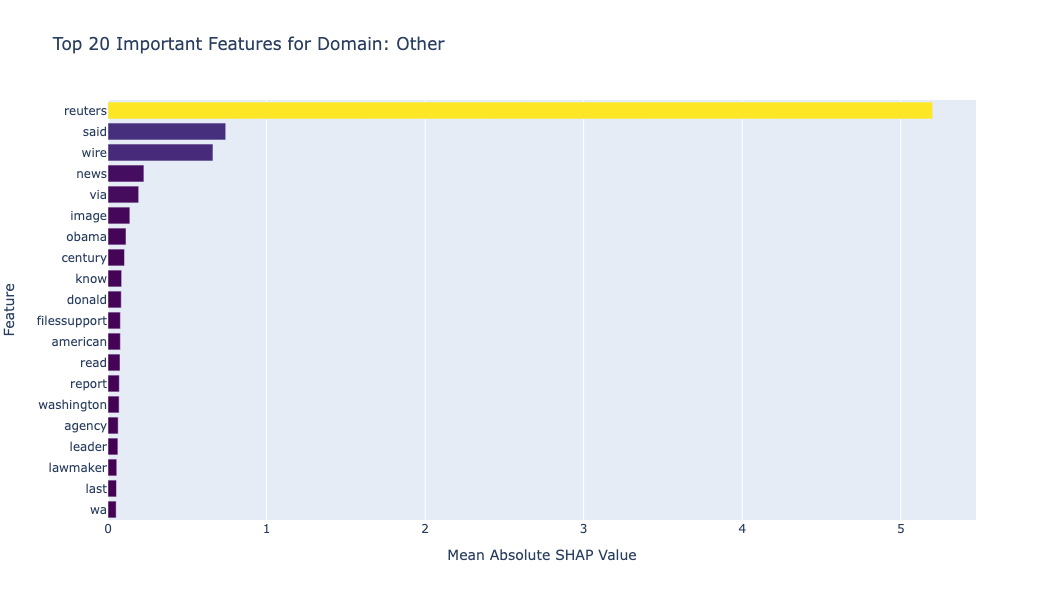

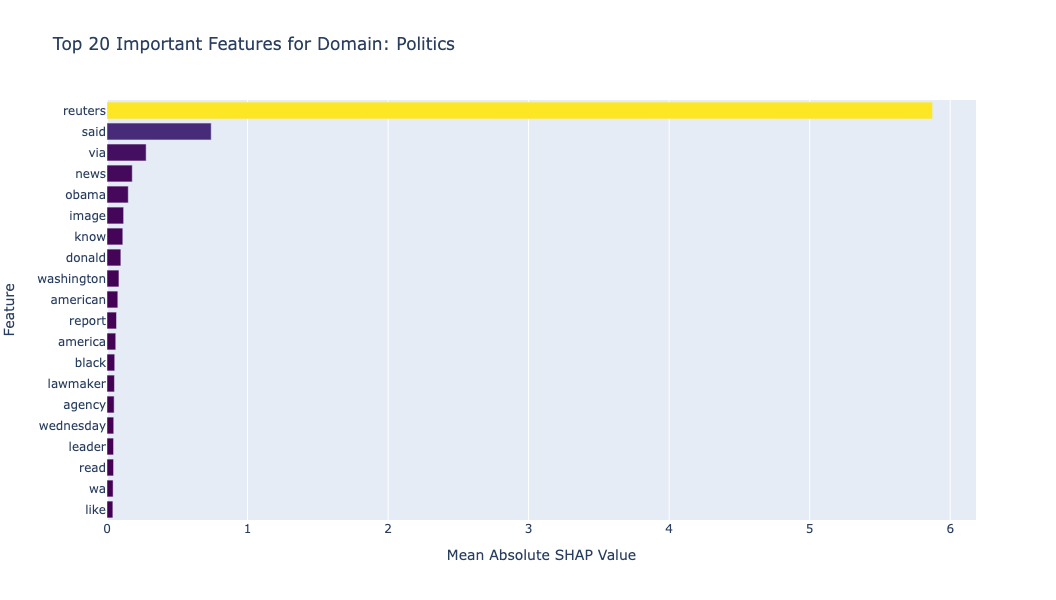

In [62]:
# 1. Create SHAP explainer and calculate SHAP values
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_vec)

# 2. Get feature names from vectorizer
feature_names = vectorizer.get_feature_names_out()

# 3. Convert sparse matrix to dense array and create DataFrame of features (optional)
X_test_dense = X_test_vec.toarray()
df_features = pd.DataFrame(X_test_dense, columns=feature_names)

# 4. Create a DataFrame for test data including domain info
# Note: Here we use y_test.index to align domains correctly
test_data = pd.DataFrame({
    'cleaned_text': X_test,
    'label': y_test,
    'domain': df.loc[y_test.index, 'domain']  # Get domain info from original df using y_test indices
})

# 5. Create SHAP values DataFrame and add domain column from test_data
shap_df = pd.DataFrame(shap_values, columns=feature_names)
shap_df['domain'] = test_data['domain'].values  # Use test_data domain, not df_test (which was undefined)

# 6. Calculate mean absolute SHAP values grouped by domain
domain_shap_importance = shap_df.groupby('domain').apply(lambda x: x.drop(columns='domain').abs().mean()).T

top_n = 20

# 7. Plot top N features by domain
for domain in domain_shap_importance.columns:
    top_features = domain_shap_importance[domain].sort_values(ascending=False).head(top_n)
    
    df_top = top_features.reset_index()
    df_top.columns = ['Feature', 'Mean |SHAP Value|']
    # print(domain)
    # print(df_top)

    fig = px.bar(
        df_top[::-1],  # Reverse for descending order in horizontal bar chart
        x='Mean |SHAP Value|',
        y='Feature',
        orientation='h',
        title=f'Top {top_n} Important Features for Domain: {domain}',
        labels={'Mean |SHAP Value|': 'Mean Absolute SHAP Value', 'Feature': 'Feature'},
        color='Mean |SHAP Value|',
        color_continuous_scale='Viridis'
    )
    
    fig.update_layout(height=600, width=1000, coloraxis_showscale=False)  # <-- This line hides the colorbar
    
    fig.show()

# Model Improvement

In [63]:
# Define parameter distribution
param_dist = {
    'max_depth': randint(3, 11),
    'learning_rate': uniform(0.01, 0.29),       # 0.01 to 0.3
    'n_estimators': randint(50, 501),
    'subsample': uniform(0.5, 0.5),             # 0.5 to 1.0
    'colsample_bytree': uniform(0.5, 0.5),      # 0.5 to 1.0
}

# Set up the classifier
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=45
)

# Stratified K-Fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Randomized Search CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring='accuracy',
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train_vec, y_train)

# Show best parameters and score
print("Best Accuracy: {:.4f}".format(random_search.best_score_))
print("Best Parameters:")
for param_name, param_value in random_search.best_params_.items():
    print(f"  {param_name}: {param_value}")


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END colsample_bytree=0.6872700594236812, learning_rate=0.28570714885887566, max_depth=5, n_estimators=121, subsample=0.7993292420985183; total time= 1.7min
[CV] END colsample_bytree=0.6872700594236812, learning_rate=0.28570714885887566, max_depth=5, n_estimators=121, subsample=0.7993292420985183; total time= 1.7min
[CV] END colsample_bytree=0.6872700594236812, learning_rate=0.28570714885887566, max_depth=5, n_estimators=121, subsample=0.7993292420985183; total time= 1.7min
[CV] END colsample_bytree=0.6872700594236812, learning_rate=0.28570714885887566, max_depth=5, n_estimators=121, subsample=0.7993292420985183; total time= 1.7min
[CV] END colsample_bytree=0.6872700594236812, learning_rate=0.28570714885887566, max_depth=5, n_estimators=121, subsample=0.7993292420985183; total time= 1.7min
[CV] END colsample_bytree=0.5780093202212182, learning_rate=0.055238410897498764, max_depth=5, n_estimators=137, subsample=0.66685430

KeyboardInterrupt: 